# ADALINEを用いた機械学習

#### 1. 必要なモジュールをインポートします

In [22]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

#### 2. ADALINEを実装します
ADALINEは、Perceptronの進化版とも言える、単一ニューロンからなるニューラルネットワークです。  
Perceptronと何が違うのか?
- コスト関数、活性化関数が導入されました
- 重みの更新は、1エポックごとに行われます

In [23]:
class ADALINE:
    
    
    def __init__(self, learning_rate=0.0005, epochs=20):
        
        self.eta = learning_rate
        self.epochs = epochs
        self.errors = []
    
    
    def fit(self, X, target):
        
        """Traning model."""
        
        self.w_ = np.random.normal(loc=0, scale=0.0001, size=X.shape[1] + 1)
        
        for _ in range(self.epochs):
            
            activation_output = np.array([])
            for xi in X:
                
                sigma = self.calculate_sigma(xi)
                act_out = self.activation_func(sigma)
                activation_output = np.append(activation_output, act_out)
            
            error = self.update_w(activation_output, X, target)
            self.errors.append(error)
    
    
    def calculate_sigma(self, xi):
        
        """Calculate the sum of products of input values and weights."""
        
        sigma = np.dot(xi, self.w_[1:]) + self.w_[0]
        return sigma
    
    
    def activation_func(self, sigma):
        
        """Apply activation function, but that is identity function for ADALINE."""
        
        return sigma
    
    
    def update_w(self, activation_output, X, target):
        
        """Calculate the variation of weights and update it."""
        
        error = target - activation_output
        cost = self.cost_func(error)
        
        delta_w_0 = self.eta * np.sum(error)
        delta_w_1_ = self.eta * np.dot(error, X)
        delta_w = np.insert(delta_w_1_, 0, delta_w_0)
        self.w_ += delta_w
        return cost
    
    
    def cost_func(self, error):
        
        """Apply cost function, but that is SSE(Sum of Squared Error)."""
        
        cost = np.sum(np.power(error, 2)) / 2
        return cost
    
    
    def predict(self, xi):
        
        """Predict the answer."""
        
        sigma = self.calculate_sigma(xi)
        activation_output = self.activation_func(sigma)
        output = self.one_step_func(activation_output)
        return output
    
    
    def one_step_func(self, activation_output):
        
        """Separate data from activation_output into 1 or 0."""
        
        return np.where(activation_output>=0.5, 1, 0)


#### 3. モデルを学習します
scikit-learnのIris-datasetsを使用しますが、このデータセットには３つの目的変数があります（３種類の花があります）。
パーセプトロンは２値分類機なので、このうち２つしか使用しません。  
つまり、0~99番目データを使用します。

In [24]:
model = ADALINE()
iris = datasets.load_iris()
X = iris.data[:100]
t = iris.target[:100]
X_train, X_test, t_train, t_test = train_test_split(X, t, stratify=t)

model.fit(X_train, t_train)

#### 4. 学習過程を表示します
Percptronとは違って確実に収束に向かっています。

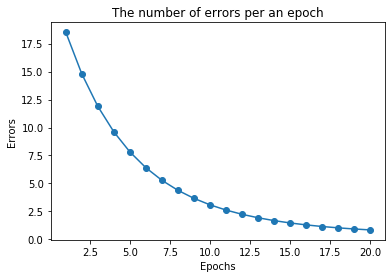

In [25]:
plt.title('The number of errors per an epoch')
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.plot(range(1, model.epochs+1), model.errors, marker='o')

#### 5. モデルを評価します

In [26]:
correctness = 0
for x, t in zip(X_test, t_test):
    output = model.predict(x)
    correctness += np.where(output == t, 1, 0)

print(f'accuracy = {correctness / len(X_test)}')

accuracy = 1.0


#### 6. 標準化を試します
つまり、各特徴量の平均を0に、標準偏差を１にします。  
そのために、各特徴量から平均を引き、標準偏差で割る必要があります。
$$ x'_j = \frac{x_j-\mu_j} {\sigma_j} $$

In [27]:
X_copied = np.copy(X_train)
mu = np.mean(X_copied, axis=0)
sigma = np.std(X_copied, axis=0)

X_standarization = (X_copied - mu) / sigma

model2 = ADALINE()
model2.fit(X_standarization, t_train)

accuracy = 1.0


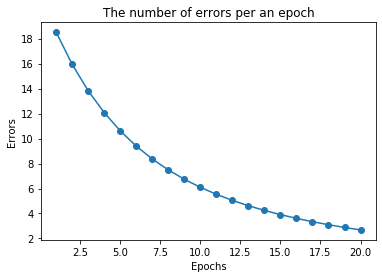

In [28]:
plt.title('The number of errors per an epoch')
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.plot(range(1, model2.epochs+1), model2.errors, marker='o')

correctness = 0
for x, t in zip(X_test, t_test):
    output = model.predict(x)
    correctness += np.where(output == t, 1, 0)

print(f'accuracy = {correctness / len(X_test)}')

#### 7. 確率的勾配降下法の実装
**確率的勾配降下法**（逐次的勾配降下法、オンライン勾配降下法とも）とは、サンプル１つ１つに対して重みの更新を行う方法のことです。  
ADALINEで実装した、バッチ勾配降下法（トレーニングデータ全体を常に考慮した重みの更新）に比べ、１つ１つのデータの影響を受けやすいが、局所的最小値を抜け出しやすいというメリットが有ります。また、**オンライン学習**（新しいトレーニングデータが届いたときに追加で学習する）を可能にします。

In [29]:
class ADALINESGD:
    
    
    def __init__(self, learning_rate=0.0005, epochs=20):
        
        self.eta = learning_rate
        self.epochs = epochs
        self.errors = []
        
    
    def fit(self, X, target):
        
        """Traning model."""
        
        self.w_ = np.random.normal(loc=0, scale=0.0001, size=X.shape[1] + 1)
        
        for _ in range(self.epochs):
            
            error_per_epoch = []
            for xi, ti in zip(X, target):
                
                sigma = self.calculate_sigma(xi)
                activation_output = self.activation_func(sigma)
                error = self.update_w(activation_output, xi, ti)
                error_per_epoch.append(error)
                
            self.errors.append(np.mean(error_per_epoch))           
    
    
    def calculate_sigma(self, xi):
        
        """Calculate the sum of products of input values and weights."""
        
        sigma = np.dot(xi, self.w_[1:]) + self.w_[0]
        return sigma
    
    
    def activation_func(self, sigma):
        
        """Apply activation function, but that is identity function for ADALINE."""
        
        return sigma
    
    
    def update_w(self, activation_output, xi, ti, return_cost=True):
        
        """Calculate the variation of weights and update it."""
        
        error = ti - activation_output        
        
        delta_w_0 = self.eta * error
        delta_w_1_ = self.eta * error * xi
        delta_w = np.insert(delta_w_1_, 0, delta_w_0)
        self.w_ += delta_w
        
        if return_cost:
            cost = self.cost_func(error)
            return cost
    
    
    def cost_func(self, error):
        
        """Apply cost function, but that is SSE(Sum of Squared Error)."""
        
        cost = (error**2) / 2
        return cost    

    
    def predict(self, xi):
        
        """Predict the answer."""
        
        sigma = self.calculate_sigma(xi)
        activation_output = self.activation_func(sigma)
        output = self.one_step_func(activation_output)
        return output
    
    
    def one_step_func(self, activation_output):
        
        """Separate data from activation_output into 1 or 0."""
        
        return np.where(activation_output>=0.5, 1, 0)
    
    
    def partica_fit(self, X, target):
        
        """Learn additionaly."""
        
        sigma = self.calculate_sigma(xi)
        activation_output = self.activation_func(sigma)
        
        for xi, ti in zip(X, target):
            self.update_w(activation_output, xi, ti, return_cost=False)


#### 8. モデルをトレーニングして結果を表示します。
縦軸の値が今までで一番小さいです。

In [30]:
model = ADALINESGD()
iris = datasets.load_iris()
X = iris.data[:100]
t = iris.target[:100]
X_train, X_test, t_train, t_test = train_test_split(X, t, stratify=t)

model.fit(X_train, t_train)

accuracy = 1.0


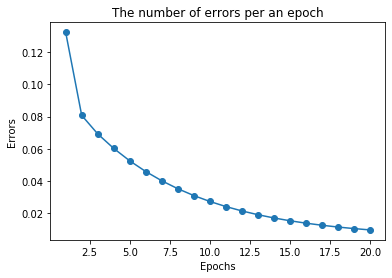

In [33]:
plt.title('The number of errors per an epoch')
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.plot(range(1, model.epochs+1), model.errors, marker='o')


correctness = 0
for x, t in zip(X_test, t_test):
    output = model.predict(x)
    correctness += np.where(output == t, 1, 0)

print(f'accuracy = {correctness / len(X_test)}')